# End to End Data Balance and Error Mitigation
This Notebook will demonstrate how to use both the Data Balance Analysis capabilities and error mitigation functions together using an example HR dataset which is a tabular dataset with a label column that indicates whether or not a person is promoted based on attributes such as education, gender, number of trainings, and other factors. 
The steps that we will take in this notebook are 

1. We will first conduct an analysis on how balanced the data is. 
2. We will train an example model to see how it performs on the data using metrics and the Responsible AI Error Analysis Dashboard. 
3. We will try to balance the data to mitigate biases that may have resulted from unbalanced data
5. We will train a new model using our data after applying the rebalance
4. We will then compare model performance before and after mitigating data imbalances by again using various performance metrics and the Error Analysis Dashboard.

First we import all the dependencies needed in our analysis. This includes the classes to produce the data balance metrics, the sklearn functions to see the model performance and the error mitigation steps like DataRebalance and DataSplit that we apply to the dataset itself. 

In [1]:
import sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder

from raimitigations.utils import split_data
import raimitigations.dataprocessing as dp
from raimitigations.databalanceanalysis import (
    FeatureBalanceMeasure,
    AggregateBalanceMeasure,
    DistributionBalanceMeasure,
)
from raimitigations.cohort import CohortManager
from download import download_datasets

### Train LightGBM Model
Now we import the tabular dataset that we will look at in the example, we load it into a pandas dataframe that we can then modify and use for all the other steps. For the data balance analysis portion we need our label columns and a list of sensitive columns that are interested in checking for balance. 

In [2]:
data_dir = "../datasets/"
download_datasets(data_dir)
df = pd.read_csv(data_dir + 'hr_promotion/train.csv')
df.drop(columns=['employee_id'], inplace=True)

In [3]:
df

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


We do some data transformation on the categorical columns in order to make the training data input in the format that the lightGBM model expects. Although lightGBM can internally deal with categorical columns that the user specifies, we need to encode those categories into integers before we are able to train the lightGBM model on it, so we create a scikit pipeline contains the encoder and the LGBM classifier.

In [4]:
cols_of_interest = ["education", "recruitment_channel"]
categorical_cols = [
    "department",
    "gender",
    "education",
    "region",
    "recruitment_channel",
]
label_col = "is_promoted"
seed = 42
# handle duplicates
df = df.drop_duplicates().dropna()
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [5]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
                ("ohe", dp.EncoderOHE(col_encode=categorical_cols, drop=False)),
                ("model", LGBMClassifier(n_estimators=50, random_state=42)),
            ])

Here we do a split on the data, train a LightGBM model using the scikit pipeline we created, and see how this model does on some test data. After this processing, we train the model and we can see that the model does well on false values, getting 97.3% of them correct, but the model does a lot worse on the true values, only identifying approximately a third of the true positives correctly. 

In [6]:
def conf_matrix(y, pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr, fpr), (fnr, tpr)) = metrics.confusion_matrix(y, pred, normalize="true")
    return pd.DataFrame(
        [
            [f"TP = {tp} ({tpr:1.2%})", f"FN = {fn} ({fnr:1.2%})"],
            [f"FP = {fp} ({fpr:1.2%})", f"TN = {tn} ({tnr:1.2%})"],
        ],
        index=["True", "False"],
        columns=["Pred 1", "Pred 0"],
    )

In [7]:
## Train a model and get accuracy numbers
# splitting the dataset
np.random.seed(42)
x_train, x_test, y_train, y_test = split_data(df, label_col, test_size=0.1)
# fitting the pipeline and predicting
pipeline.fit(x_train, y_train)
pred = pipeline.predict(x_test)


print("number of errors on test dataset: " + str(sum(pred != y_test)))
print(conf_matrix(y_test, pred))
print(classification_report(y_test, pred))

number of errors on test dataset: 293
                  Pred 1              Pred 0
True   TP = 142 (33.57%)   FN = 281 (66.43%)
False    FP = 12 (0.27%)  TN = 4426 (99.73%)
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4438
           1       0.92      0.34      0.49       423

    accuracy                           0.94      4861
   macro avg       0.93      0.67      0.73      4861
weighted avg       0.94      0.94      0.93      4861



### Error Analysis on Baseline Model
Now that we have a baseline model to work with, we can see how this model is doing overall on the data and see if there are any cohorts within the data that the model performs worse on. Even if the model has a high accuracy, we want to make sure that accuracy is applicable over different sensitive groups. We use the [Error Analysis Dashboard](https://erroranalysis.ai/) to determine which cohorts of data this model performs worse on. To install this library, use the following command:

```console
> pip install raiwidgets
```

In the following cell, we set up the parameters required by the [Responsible AI Toolbox](https://github.com/microsoft/responsible-ai-toolbox).

In [8]:
from raiwidgets import ResponsibleAIDashboard
from responsibleai import RAIInsights
from raiwidgets.cohort import Cohort, CohortFilter, CohortFilterMethods

df_train = x_train.copy()
df_train[label_col] = y_train
df_test = x_test.copy()
df_test[label_col] = y_test

rai_insights = RAIInsights(pipeline, df_train, df_test, label_col, 'classification',
                           categorical_features=pipeline['ohe'].get_encoded_columns())

# Error Analysis
rai_insights.error_analysis.add()

rai_insights.compute()

Using categorical_feature in Dataset.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Us

We can now create the dashboard, which will be available in the local host. Open your browser on the indicated local host address and you'll be able to interact with the dashboard.

In [9]:
ResponsibleAIDashboard(rai_insights)

ResponsibleAI started at http://localhost:5000


Since the error analysis dashboard is interactive and too large to render on Github, we will include screenshots from our analysis.

![screen1](./images/error_analysis_adult_census3.png)

![screen2](./images/error_analysis1.png)

![screen3](./images/error_analysis2.png)

From these screenshots we can see that if we zoom in on certain cohorts that the model is getting more errors on, that region, department and education are all attributes that are involved in those cohorts. For the purpose of this example, we chose remove some of the other columns like KPIs_met from the error analysis since we want to focus on attributes that may lead to biases rather than more measurable attributes. We will focus on analyzing and mitigating errors within the department and education columns for the rest of the analysis. 

### Data Balance Analysis
First we can take a look at the feature balance measures. These measures indicate the difference in the label column amongst different feature values. For example the first row here indicates if people with the "Masters & above" education has a different proportion of people receiving the promoted outcome than those that have a Bachelor's. Lower values of these measures indicates that the amounts of people with class A vs versus those with class B with a label of 1 is similar. The t-test value can also tell us if the difference we see is statistically significant.

In [10]:
feature_measures = FeatureBalanceMeasure(cols_of_interest, label_col)

train_df = x_train.copy()
train_df[label_col] = y_train

feat_measures1 = feature_measures.measures(train_df)
feat_measures1.head()

,ClassA,ClassB,FeatureName,dp,pmi,sdc,ji,krc,llr,t_test,ttest_pvalue
0,Master's & above,Bachelor's,education,0.017814,0.197252,0.004788,0.005594,4.996442,-0.622067,0.262386,0.408789
1,Master's & above,Below Secondary,education,0.022587,0.257448,0.069726,0.076144,-27.035372,3.718893,-2.623174,0.059886
2,Bachelor's,Below Secondary,education,0.004773,0.060196,0.064938,0.070550,-32.031814,4.340960,-2.885561,0.051023
0,sourcing,other,recruitment_channel,0.002630,0.030454,-0.000794,-0.000925,1.579734,-0.240590,0.085323,0.469888
1,sourcing,referred,recruitment_channel,-0.038804,-0.366366,0.048196,0.053285,-18.723860,2.639673,-1.733789,0.112546


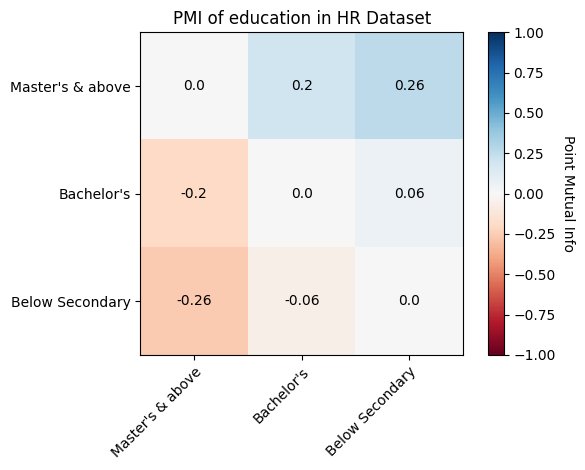

In [11]:
%matplotlib inline 
educations = train_df["education"].unique()
education_dp_values = feat_measures1[feat_measures1["FeatureName"] == "education"][
    ["ClassA", "ClassB", "pmi"]
]
education_dp_array = np.zeros((len(educations), len(educations)))

for idx, row in education_dp_values.iterrows():
    class_a = row[0]
    class_b = row[1]
    dp_value = row[2]
    i, j = np.where(educations == class_a)[0][0], np.where(educations == class_b)
    dp_value = round(dp_value, 2)
    education_dp_array[i, j] = dp_value
    education_dp_array[j, i] = -1 * dp_value

colormap = "RdBu"
dp_min, dp_max = -1.0, 1.0

fig, ax = plt.subplots()
im = ax.imshow(education_dp_array, vmin=dp_min, vmax=dp_max, cmap=colormap)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Point Mutual Info", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(educations)))
ax.set_yticks(np.arange(len(educations)))
ax.set_xticklabels(educations)
ax.set_yticklabels(educations)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(educations)):
    for j in range(len(educations)):
        text = ax.text(
            j, i, education_dp_array[i, j], ha="center", va="center", color="k"
        )

ax.set_title("PMI of education in HR Dataset")
fig.tight_layout()
plt.show()

Next we can take a look at the distribution balance measures. These measures each of the columns of interest that we selected to the uniform distribution of those values. Values that are closer to zero indicate that the difference between the actual distribution of the data and the uniform distribution of values. We find that these values are pretty far from zero, so they don't align to a uniform distribution well before we make any modifications to the original data. 

In [12]:
dist_measures = DistributionBalanceMeasure(cols_of_interest)
dist_measures1 = dist_measures.measures(train_df)
dist_measures1

,FeatureName,kl_divergence,js_dist,wasserstein_dist,inf_norm_dist,total_variation_dist,chi_sq_p_value,chi_sq_stat
0,education,0.434946,0.358906,0.236105,0.354158,0.354158,0.0,30343.542312
1,recruitment_channel,0.327144,0.315774,0.208248,0.312371,0.312371,0.0,20349.678919


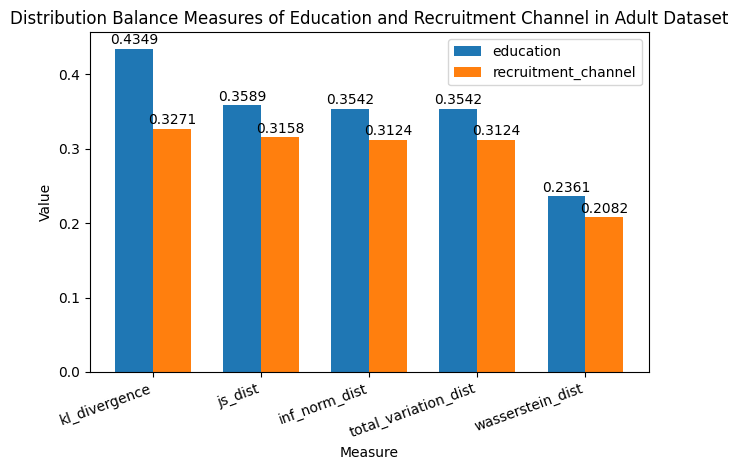

In [13]:
%matplotlib inline 
measures_of_interest = [
    "kl_divergence",
    "js_dist",
    "inf_norm_dist",
    "total_variation_dist",
    "wasserstein_dist",
]
education_measures = dist_measures1[dist_measures1["FeatureName"] == "education"].iloc[
    0
]
recruitment_measures = dist_measures1[
    dist_measures1["FeatureName"] == "recruitment_channel"
].iloc[0]
education_array = [
    round(education_measures[measure], 4) for measure in measures_of_interest
]
recruitment_array = [
    round(recruitment_measures[measure], 4) for measure in measures_of_interest
]

x = np.arange(len(measures_of_interest))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, education_array, width, label="education")
rects2 = ax.bar(x + width / 2, recruitment_array, width, label="recruitment_channel")

ax.set_xlabel("Measure")
ax.set_ylabel("Value")
ax.set_title(
    "Distribution Balance Measures of Education and Recruitment Channel in Adult Dataset"
)
ax.set_xticks(x)
ax.set_xticklabels(measures_of_interest)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation=20, ha="right", rotation_mode="default")


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 1),  # 1 point vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

We can also look at aggregate balance measures which indicate a notion of overall inequality in the data. We can see that the Atkinson Index is 0.79. This means that in order to create a perfectly balanced dataset over these measures we would need to forgo 79.9% of the data. 

In [14]:
agg_measures = AggregateBalanceMeasure(cols_of_interest)
agg_measures1 = agg_measures.measures(train_df)
agg_measures1

,theil_l_index,theil_t_index,atkinson_index
0,1.600814,0.762696,0.798268


### Error Mitigation: Rebalancing dataset

In order to rebalance the data we can choose from three different methods of under or oversampling. These are SMOTE, Tomek and SMOTE-Tomek. SMOTE is an oversampling technique for the less represented class. Tomek is an undersampling technique that would be applied to the more represented class. Smote-Tomek is when both of these methods are applied in conjunction on the dataset. In this example, we will choose to use the SMOTE sampling technique on the columns of interest. The rebalance operation is originally aimed for a single column, that is, the entire dataset is rebalanced based on one column. However, the ``CohortManager`` class allows us to specify a set of cohorts, where the rebalance operation will then be applied to each cohort individually.

In the next cell, we will rebalance our dataset using the `recruitment_channel` column as the target column, and the `education` column as the cohort division, that is, the ``CohortManager`` class will first separate the dataset into multiple cohorts, one for each of the existing values in the `education` column. Next, it will run the rebalance operation (over the `recruitment_channel` column) for each cohort separately.

In [15]:
train_df2 = train_df.copy()

rebalance = dp.Rebalance(k_neighbors=4, verbose=False)
cht_manager = CohortManager(transform_pipe=rebalance, cohort_col=['education'])
smote_df = cht_manager.fit_resample(df=train_df2, rebalance_col='recruitment_channel')

smote_df

,department,region,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,recruitment_channel
0,Procurement,region_7,Bachelor's,f,1,29,3.000000,3,0,0,74,0,other
1,HR,region_2,Bachelor's,f,1,56,3.000000,5,0,0,46,0,other
2,HR,region_7,Bachelor's,f,2,30,4.000000,6,0,0,46,0,sourcing
3,Sales & Marketing,region_7,Bachelor's,m,2,31,4.000000,6,0,0,48,0,other
4,Finance,region_2,Bachelor's,m,2,47,3.000000,7,1,0,56,0,sourcing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72892,Technology,region_2,Master's & above,m,1,40,4.000000,13,1,0,81,0,sourcing
72893,Operations,region_22,Master's & above,m,1,37,3.000000,7,0,0,61,0,sourcing
72894,Operations,region_1,Master's & above,m,1,30,3.254223,5,0,0,56,0,sourcing
72895,Sales & Marketing,region_22,Master's & above,m,1,45,4.595457,16,0,0,55,0,sourcing


In [16]:
print(x_train.shape[0])
print(smote_df.shape[0])

43746
72897


After applying the SMOTE Rebalancing mitigation, we get a dataset that is much larger than the original data frame. The SMOTE Method applies oversampling in order to balance the dataset. 

### New Model on Rebalanced Datasets
After applying the SMOTE Method on the data, we can then train a new lightGBM model on this newly balanced data and see if there are differences in model performance based on this balancing. We compare the results below and find that the new model trained on the data post rebalancing does a better job predicting true positives than the original model and thus has greater recall and overall precision. So not only does data rebalancing help with making sure a model is less biased, it also helps the model actually fit and be able to predict the data outcomes more accurately. 

In [17]:
x_train2 = smote_df.drop(columns=[label_col])
y_train2 = smote_df[label_col]

pipeline2 = Pipeline([
                ("ohe", dp.EncoderOHE(col_encode=categorical_cols, drop=False)),
                ("model", LGBMClassifier(n_estimators=50, random_state=42)),
            ])

pipeline2.fit(x_train2, y_train2)

pred2 = pipeline2.predict(x_test)
pred_model1 = pipeline.predict(x_test)

We compare the number of error that the model 1 that was trained before rebalancing and model 2 that was trained after rebalancing have and we find that overall there are less errors with model 2. 

In [18]:
# Compare Results
class color:
    PURPLE = "\033[95m"
    CYAN = "\033[96m"
    DARKCYAN = "\033[36m"
    BLUE = "\033[94m"
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"
    END = "\033[0m"


print("")
print(
    color.PURPLE
    + color.BOLD
    + "BEFORE: "
    + color.END
    + "number of test dataset instances: "
    + color.BOLD
    + color.GREEN
    + str(len(y_test))
    + color.END
)
print(
    "      : number of errors on test dataset: "
    + color.BOLD
    + color.RED
    + str(sum(pred_model1 != y_test))
    + color.END
)
print("")
print(
    color.PURPLE
    + color.BOLD
    + "AFTER:  "
    + color.END
    + "number of test dataset instances: "
    + color.BOLD
    + color.GREEN
    + str(len(y_test))
    + color.END
)
print(
    "     :  number of errors on test dataset: "
    + color.BOLD
    + color.RED
    + str(sum(pred2 != y_test))
    + color.END
)
print("")


BEFORE: number of test dataset instances: 4861
      : number of errors on test dataset: 293

AFTER:  number of test dataset instances: 4861
     :  number of errors on test dataset: 299



In [19]:
# compare conf matrices
print("-----------------------------------------------------------------------")
print("")
print(color.BLUE + color.BOLD + "BEFORE: conf_matrix:" + color.END)
print("--------------------")
print(conf_matrix(y_test, pred_model1))
print("")
print(color.BLUE + color.BOLD + "AFTER: conf_matrix:" + color.END)
print("-------------------")
print(conf_matrix(y_test, pred2))
print("-----------------------------------------------------------------------")
print("-----------------------------------------------------------------------")
print("")

-----------------------------------------------------------------------

BEFORE: conf_matrix:
--------------------
                  Pred 1              Pred 0
True   TP = 142 (33.57%)   FN = 281 (66.43%)
False    FP = 12 (0.27%)  TN = 4426 (99.73%)

AFTER: conf_matrix:
-------------------
                  Pred 1              Pred 0
True   TP = 136 (32.15%)   FN = 287 (67.85%)
False    FP = 12 (0.27%)  TN = 4426 (99.73%)
-----------------------------------------------------------------------
-----------------------------------------------------------------------



In [20]:
# compare classification report
print(color.YELLOW + color.BOLD + "BEFORE: classification_report:" + color.END)
print("--------------------------------")
print(classification_report(y_test, pred_model1))
print(color.YELLOW + color.BOLD + "AFTER: classification_report:" + color.END)
print("--------------------------------")
print(classification_report(y_test, pred2))

BEFORE: classification_report:
--------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4438
           1       0.92      0.34      0.49       423

    accuracy                           0.94      4861
   macro avg       0.93      0.67      0.73      4861
weighted avg       0.94      0.94      0.93      4861

AFTER: classification_report:
--------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4438
           1       0.92      0.32      0.48       423

    accuracy                           0.94      4861
   macro avg       0.93      0.66      0.72      4861
weighted avg       0.94      0.94      0.92      4861



As we can see, we didn't manage to improve the performance over the test dataset after rebalancing it, but we can still check to see if we were able to improve the data balance metrics. Now we analyze the data balance analysis on the newly rebalanced data and see what the difference is from before applying SMOTE and after.

The feature value measures before rebalancing don't indicate a lot of discrepancy in the outcome within specific features within a class since the values such as demographic parity which is on a 0 to 1 scale are very close to zero. After rebalancing, we still have similarly low values of these measures but there is not a significant improvement since they already started low.

In [27]:
feat_measures1

,ClassA,ClassB,FeatureName,dp,pmi,sdc,ji,krc,llr,t_test,ttest_pvalue
0,Master's & above,Bachelor's,education,0.017814,0.197252,0.004788,0.005594,4.996442,-0.622067,0.262386,0.408789
1,Master's & above,Below Secondary,education,0.022587,0.257448,0.069726,0.076144,-27.035372,3.718893,-2.623174,0.059886
2,Bachelor's,Below Secondary,education,0.004773,0.060196,0.064938,0.070550,-32.031814,4.340960,-2.885561,0.051023
0,sourcing,other,recruitment_channel,0.002630,0.030454,-0.000794,-0.000925,1.579734,-0.240590,0.085323,0.469888
1,sourcing,referred,recruitment_channel,-0.038804,-0.366366,0.048196,0.053285,-18.723860,2.639673,-1.733789,0.112546
2,other,referred,recruitment_channel,-0.041434,-0.396820,0.048990,0.054210,-20.303594,2.880263,-1.819112,0.105255


In [28]:
feature_measures.measures(smote_df)

,ClassA,ClassB,FeatureName,dp,pmi,sdc,ji,krc,llr,t_test,ttest_pvalue
0,Bachelor's,Below Secondary,education,0.007317,0.127051,0.049504,0.052789,-39.954385,4.470495,-2.572282,0.061853
1,Bachelor's,Master's & above,education,-0.010460,-0.157473,-0.003277,-0.003691,-5.858737,0.644341,-0.220763,0.422882
2,Below Secondary,Master's & above,education,-0.017777,-0.284524,-0.052781,-0.056479,34.095648,-3.826154,2.351520,0.071519
0,other,sourcing,recruitment_channel,0.011770,0.148923,0.009862,0.011314,0.067773,0.148923,0.000000,0.500000
1,other,referred,recruitment_channel,0.050002,0.886267,0.041898,0.046479,0.287918,0.886267,0.000000,0.500000
2,sourcing,referred,recruitment_channel,0.038232,0.737344,0.032036,0.035165,0.220145,0.737344,0.000000,0.500000


When we compare the distribution measures before and after rebalancing, we find that the data is much more evenly distributed (close to the uniform distribution) for the two columns of interest after rebalancing the data using the SMOTE algorithm

In [23]:
# before
dist_measures1

,FeatureName,kl_divergence,js_dist,wasserstein_dist,inf_norm_dist,total_variation_dist,chi_sq_p_value,chi_sq_stat
0,education,0.434946,0.358906,0.236105,0.354158,0.354158,0.0,30343.542312
1,recruitment_channel,0.327144,0.315774,0.208248,0.312371,0.312371,0.0,20349.678919


In [24]:
# after
dist_measures.measures(smote_df)

,FeatureName,kl_divergence,js_dist,wasserstein_dist,inf_norm_dist,total_variation_dist,chi_sq_p_value,chi_sq_stat
0,education,0.43447,0.35937,0.233928,0.350892,0.350892,0.0,50099.684185
1,recruitment_channel,0.00000,0.00000,0.000000,0.000000,0.000000,1.0,0.000000


The Atkinson index which gives us the overall notion of inequality before and after rebalancing shows us that in order to get a perfectly balanced dataset, we no longer need to forgo any of the data.

In [25]:
# before
agg_measures1

,theil_l_index,theil_t_index,atkinson_index
0,1.600814,0.762696,0.798268


In [26]:
# after
agg_measures.measures(smote_df)

,theil_l_index,theil_t_index,atkinson_index
0,0.995942,0.43447,0.630625
